In [775]:
import os
import sys
sys.path.append('./src') 
os.environ['CUDA_VISIBLE_DEVICES'] = '6'
import yaml

from datasets import build_dataset, build_transforms
from denoiser import get_denoiser
from models import create_vae

import matplotlib.pyplot as plt 
import numpy as np

from backbones import get_backbone
from denoiser import get_denoiser, Denoiser
from models import create_vae, AutoencoderKL, create_emar_model, EncoderMAR, \
    get_unmasked_indices, ICLContextEncoder

In [962]:
dataset = "mvtec_ad"
category = "screw"
num_inference_steps = 50
device = 'cuda'
num_samples = 1
start_step = 64

In [963]:
model_kwargs = {
    'model_type': 'efficientnet-b4',
    'outblocks': (1, 5, 9, 21),
    'outstrides': (2, 4, 8, 16),
    'pretrained': True,
    'stride': 16
}
print(f"Using feature space reconstruction with {model_kwargs['model_type']} backbone")
feature_extractor = get_backbone(**model_kwargs)
feature_extractor.to(device).eval()

Using feature space reconstruction with efficientnet-b4 backbone


BackboneWrapper(
  (backbone): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          48, 12, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          12, 48, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSame

In [964]:
from torch.utils.data import DataLoader
import torch

img_size = 256

normal_dataset = build_dataset(
    dataset_name=dataset,
    data_root = f"data/{dataset}",
    train=False,
    img_size=img_size,
    transform_type="default",
    category = category,
    normal_only = True
)
anom_dataset = build_dataset(
    dataset_name=dataset,
    data_root = f"data/{dataset}",
    train=False,
    img_size=img_size,
    transform_type="default",
    category = category,
    anom_only = True
)
train_dataset = build_dataset(
    dataset_name=dataset,
    data_root = f"data/{dataset}",
    train=True,
    img_size=img_size,
    transform_type="default",
    category = category,
)
print(len(normal_dataset))
print(len(anom_dataset))

41
119


In [965]:
# log_dir = f"./results/ad_unet_vae_ddad/{category}"
log_dir = f"./results/exp_unet_vae_ad/{category}"
config_path = os.path.join(log_dir, "config.yaml")
ckpt_path = os.path.join(log_dir, "model_latest.pth")

with open(config_path, 'r') as stream:
    try:
        config = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

seed = config['meta']['seed']
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed) 

config["diffusion"]["num_sampling_steps"] = str(num_inference_steps)
img_size = config['data']['img_size']
device = device
num_samples = num_samples

# build backbone model
if 'vae' not in config.keys():
    config['vae'] = config['backbone']
    
backbone = create_vae(**config['vae'])
backbone.to(device).eval()

mim_in_sh = (16, 16, 16)

Working with z of shape (1, 16, 16, 16) = 4096 dimensions.
Loading pre-trained KL-VAE
Missing keys:
[]
Unexpected keys:
[]
Restored from ./weights/vae/kl16.ckpt


In [966]:
backbone_embed_dim = config['vae']['embed_dim']
backbone_stride = config['vae']['stride']
img_size = config['data']['img_size']
# mim_in_sh = (backbone_embed_dim, img_size // backbone_stride, img_size // backbone_stride)
mim_in_sh = (272, img_size // backbone_stride, img_size // backbone_stride)
model: Denoiser = get_denoiser(**config['diffusion'], input_shape=mim_in_sh)
# ckpt_path = f"/home/haselab/projects/sakai/AnoMAR/AnoMAR/ddad_models/{category}"

model_ckpt = torch.load(ckpt_path, map_location='cpu', weights_only=True)

# Create a list to store the keys that need to be renamed
keys_to_replace = []

# Identify the keys to be renamed
for k in model_ckpt.keys():
    if 'module' in k:
        keys_to_replace.append(k)

# Modify the keys outside the loop
for k in keys_to_replace:
    model_ckpt[k.replace('module.', 'net.')] = model_ckpt.pop(k)

results = model.load_state_dict(model_ckpt, strict=False)
print(results)
model.to(device).eval()

<All keys matched successfully>


Denoiser(
  (cls_embed): Embedding(15, 256)
  (net): UNetModel(
    (time_embed): Sequential(
      (0): Linear(in_features=256, out_features=1024, bias=True)
      (1): SiLU()
      (2): Linear(in_features=1024, out_features=1024, bias=True)
    )
    (input_blocks): ModuleList(
      (0): TimestepEmbedSequential(
        (0): Conv2d(272, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1-2): 2 x TimestepEmbedSequential(
        (0): ResBlock(
          (in_layers): Sequential(
            (0): GroupNorm32(32, 256, eps=1e-05, affine=True)
            (1): SiLU()
            (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (h_upd): Identity()
          (x_upd): Identity()
          (emb_layers): Sequential(
            (0): SiLU()
            (1): Linear(in_features=1024, out_features=256, bias=True)
          )
          (out_layers): Sequential(
            (0): GroupNorm32(32, 256, eps=1e-05, affine=True)
          

In [967]:
from mask import RandomMaskCollator, BlockRandomMaskCollator, CheckerBoardMaskCollator, SlidingWindowMaskCollator, indices_to_mask, mask_to_indices
from datasets import EvalDataLoader
# mask_strategy = "random"
# mask_strategy = "random"
mask_strategy = "random"

# mask_ratio = config['data']['mask']['ratio']
mask_ratio = 0.75
patch_size = 1
if mask_strategy == "random":
    mask_collator = RandomMaskCollator(
        ratio=mask_ratio, input_size=mim_in_sh[1], patch_size=patch_size, min_ratio=mask_ratio, max_ratio=mask_ratio
    )
elif mask_strategy == "block":
    kwargs = {
        "aspect_min": 0.75,
        "aspect_max": 1.5,
        "scale_min": 0.4,
        "scale_max": 0.7,
        "num_blocks": 2,
    }
    mask_collator = BlockRandomMaskCollator(
        input_size=mim_in_sh[1], patch_size=patch_size, mask_ratio=mask_ratio, **kwargs
    )
elif mask_strategy == "checkerboard":
    kwargs = {
        "min_divisor": 3,
        "max_divisor": 3,
        "mode": "random"
    }
    mask_collator = CheckerBoardMaskCollator(
        input_size=mim_in_sh[1], patch_size=patch_size, **kwargs
    )
elif mask_strategy == "sliding_window":
    mask_collator = SlidingWindowMaskCollator(
        input_size=mim_in_sh[1], patch_size=patch_size, **config['data']['mask']
    )
else:
    raise ValueError(f"Invalid mask strategy: {mask_strategy}")

bs = 8

# normal_dataloader = EvalDataLoader(normal_dataset, num_repeat=bs, collate_fn=mask_collator)
# anom_dataloader = EvalDataLoader(anom_dataset, num_repeat=bs, collate_fn=mask_collator)
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=4, drop_last=True)
normal_dataloader = DataLoader(normal_dataset, batch_size=bs, shuffle=False, num_workers=4, drop_last=False)
anom_dataloader = DataLoader(anom_dataset, batch_size=bs, shuffle=False, num_workers=4, drop_last=False)

In [968]:
masks = mask_collator.collate_all_masks(1)

batch = list(iter(train_loader))[0]

# batch, mask_indices = next(iter(normal_dataloader))
# ensure same mask for all samples
# mask_indices = torch.stack([mask_indices[0] for _ in range(bs)])

num_patches = mim_in_sh[1] ** 2
# mask = indices_to_mask(mask_indices, num_patches)
mask = masks[0].unsqueeze(0).repeat(bs, 1)

# mask_indices = mask_indices.to(device)
images = batch["samples"].to(device)
labels = batch["clslabels"].to(device)
# gt_masks = batch["masks"]  # (B, 1, H, W) 
paths = batch["filenames"]
print(paths)

['data/mvtec_ad/screw/train/good/179.png', 'data/mvtec_ad/screw/train/good/219.png', 'data/mvtec_ad/screw/train/good/102.png', 'data/mvtec_ad/screw/train/good/244.png', 'data/mvtec_ad/screw/train/good/087.png', 'data/mvtec_ad/screw/train/good/095.png', 'data/mvtec_ad/screw/train/good/090.png', 'data/mvtec_ad/screw/train/good/209.png']


In [969]:
from einops import rearrange

@torch.no_grad()
def encode_images(x):
    post = backbone.encode(x)
    return post.sample().mul_(0.2325)

@torch.no_grad()
def decode_images(x):
    return backbone.decode(x / 0.2325)

def reshape_mask(m):  
    """ (B, hw) -> (B, hp, wp) """
    m = rearrange(m, 'b (h w) -> b h w', h=mim_in_sh[1], w=mim_in_sh[2])
    m = torch.repeat_interleave(m, repeats=patch_size, dim=1)
    m = torch.repeat_interleave(m, repeats=patch_size, dim=2)
    m = m.float()
    return m

### Unconditional Sampling

In [970]:
@torch.no_grad()
def sample(input_shape, labels, cond, mask_indices, strategy="ddim"):
    sample = model.sample(input_shape, labels, z=cond, mask_indices=mask_indices, strategy=strategy)  # (B, d, h, w)
    return sample

def postprocess(x):
    x = x / 2 + 0.5
    return x.clamp(0, 1)

def convert2image(x):
    if x.dim() == 3:
        return x.permute(1, 2, 0).cpu().numpy()
    elif x.dim() == 4:
        return x.permute(0, 2, 3, 1).cpu().numpy()
    else:
        return x.cpu().numpy()

in_sh = (bs, *mim_in_sh)
# in_sh = (bs, 3, 256, 256)
# preds = sample(in_sh, labels, cond=None, mask_indices=None)  # (B, d, h, w)
# preds = sample(in_sh, labels, cond=None, mask_indices=None, strategy="org")  # (B, d, h, w)

In [971]:
# latents_org = feature_extractor(images)
# start_t = torch.tensor([0] * bs, device=device)
# end_t = torch.tensor([num_inference_steps] * bs, device=device)

# with torch.no_grad():
#     last_latents = model.ddim_reverse_sample(
#         latents_org, start_t, labels, eta=0.0
#     )
#     denoised_latents = model.denoise_from_intermediate(
#         last_latents, end_t, labels, eta=0.0, sampler="ddim"
#     )

# decoded_imgs_last = postprocess(decode_images(last_latents))
# decoded_images_org = postprocess(decode_images(latents_org))
# decoded_iamges_denoised = postprocess(decode_images(denoised_latents))

# fig, ax = plt.subplots(3, bs, figsize=(bs * 3, 9))
# for i in range(bs):
#     ax[0, i].imshow(convert2image(decoded_images_org[i]))
#     ax[1, i].imshow(convert2image(decoded_imgs_last[i]))
#     ax[2, i].imshow(convert2image(decoded_iamges_denoised[i]))
# plt.show()

In [972]:
def calculate_log_pdf(x):
    ll = -0.5 * (x ** 2 + np.log(2 * np.pi))
    ll = ll.sum(dim=(1, 2, 3))
    return ll

from tqdm import tqdm
start_t = torch.tensor([0] * bs, device=device)
normal_lls = []
for batch in tqdm(normal_dataloader):
    images = batch["samples"].to(device)
    labels = batch["clslabels"].to(device)
    
    with torch.no_grad():
        latents_org = feature_extractor(images)
        latents_last = model.ddim_reverse_sample(
            latents_org, start_t, labels, eta=0.0
        )
    
    ll = calculate_log_pdf(latents_last.cpu())
    normal_lls.extend(ll)

anom_lls = []
for batch in tqdm(anom_dataloader):
    images = batch["samples"].to(device)
    labels = batch["clslabels"].to(device)
    
    with torch.no_grad():
        latents_org = feature_extractor(images)
        latents_last = model.ddim_reverse_sample(
            latents_org, start_t, labels, eta=0.0
        )
    
    ll = calculate_log_pdf(latents_last.cpu())
    anom_lls.extend(ll)    

100%|██████████| 15/15 [00:17<00:00,  1.15s/it]


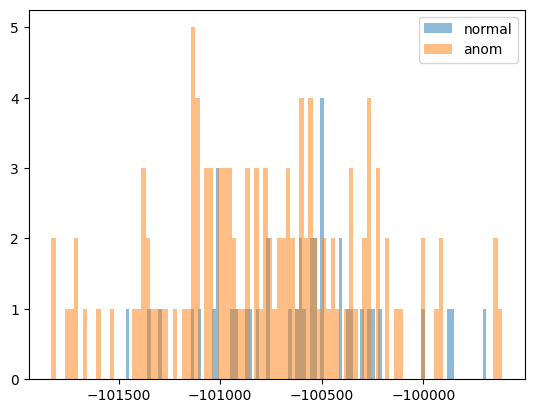

In [973]:
# plot histogram
plt.hist(normal_lls, bins=100, alpha=0.5, label="normal")
plt.hist(anom_lls, bins=100, alpha=0.5, label="anom")
plt.legend()
plt.show()

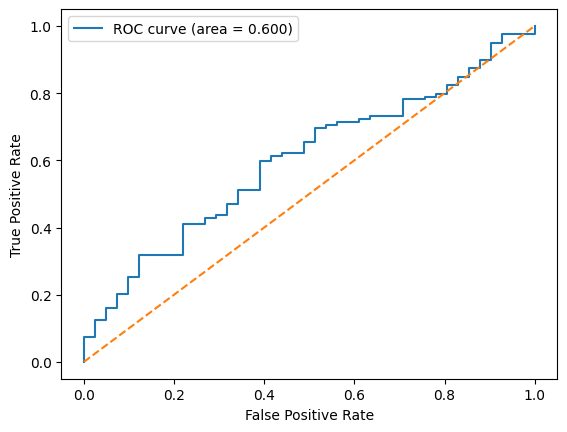

In [974]:
# plot ROC curve
from sklearn.metrics import roc_curve, roc_auc_score
normal_lls = np.array(normal_lls) * -1
anom_lls = np.array(anom_lls) * -1
y_true = np.concatenate([np.zeros(len(normal_lls)), np.ones(len(anom_lls))])
y_score = np.concatenate([normal_lls, anom_lls])
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = roc_auc_score(y_true, y_score)

fig, ax = plt.subplots()
ax.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.3f})")
ax.plot([0, 1], [0, 1], linestyle="--")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend()
plt.show()

### DDRM

In [134]:
import torch.nn.functional as F

def expand_bool_mask(m, p: int):
    # m: (B, h, w) 
    if p <= 0:
        return m
    m_float = m.float()  # (B, 1, h, w)
    dilated = F.max_pool2d(m_float, kernel_size=2*p+1, stride=1, padding=p)
    return dilated.squeeze(1) > 0

def gt_mask_to_mask(gt_mask, in_sh, expand_size):
    # gt_mask: (B, 1, H, W)
    gt_mask = expand_bool_mask(gt_mask, 3).unsqueeze(1).float()  # (B, 1, H, W)
    mask = F.interpolate(gt_mask, size=(in_sh[1], in_sh[2]), mode='nearest')
    mask = expand_bool_mask(mask, expand_size)
    return mask 

exp_size = 1
use_gt_mask = False

if use_gt_mask:
    gt_masks_ = gt_masks.clone()
    # gt_masks_ = seg_masks[:, 5]  # (B, H, W)
    gt_masks_ = gt_mask_to_mask(gt_masks_, in_sh, expand_size=exp_size) # (B, h, w)
    mask = gt_masks_.to(device)
    mask = rearrange(mask, 'b h w -> b (h w)')
    mask = reshape_mask(mask)
else:
    mask = mask.to(device)
    mask = reshape_mask(mask)

In [135]:
# Initialize x_T
x_T = torch.randn(in_sh).to(device)  # (B, d, h, w)

# indices = list(range(model.sample_diffusion.num_timesteps))[::-1]
cls_embed = model.cls_embed(labels)  # (B, Z)
# cls_embed = None
model_kwargs = dict(c=cls_embed, z=None, mask_indices=None, z_vis=None)
sample_fn = model.net.forward

# Extract original latents
x_org = encode_images(images)  # (B, d, h, w)
# x_org = images
inv_mask = 1 - mask.float() # (B, h, w), 0: masked, 1: unmasked
mask, inv_mask = mask.unsqueeze(1), inv_mask.unsqueeze(1)  # (B, 1, h, w) 

In [136]:
# Set eta
eta = 0.85
eta_b = 1.0

In [137]:
mask.shape

torch.Size([8, 1, 14, 14])

In [138]:
# DDRM Loop

from tqdm import tqdm
import math

indices = list(range(model.sample_diffusion.num_timesteps))[::-1]
alphas = 1.0 - model.sample_diffusion.betas
sigmas = np.sqrt(1/alphas - 1)

def sample_ddrm(x, x_org, mask, inv_mask, sigmas, alphas, indices, device, bs, model):
    indices = tqdm(indices)
    for i in indices:
        t = torch.tensor([i] * bs).to(device)
        
        # For first denoising step
        if i == model.sample_diffusion.num_timesteps - 1:
            noise = torch.randn(x_org.shape, device=device)
            x_m = sigmas[i] * noise * mask   # unconditional for masked pixels
            x_v = x_org * inv_mask + sigmas[i] * noise * inv_mask # conditional for unmasked pixels
            x = x_m + x_v
            # scale x_t to VP domain
            x = x * math.sqrt(alphas[i])
            x.to(device)
            continue
        
        with torch.no_grad():
            out = model.sample_diffusion.p_sample(
                sample_fn,
                x,
                t,
                clip_denoised=False,
                denoised_fn=None,
                cond_fn=None,
                model_kwargs=model_kwargs,
                temperature=1.0,
            )
            # pred_x0 = out["pred_xstart"]
            eps = out["eps"]
            pred_x0 = x - sigmas[i] * eps 
        
        # Predict x_{t-1}
        sigma_t = sigmas[i]
        prev_sigma_t = sigmas[i+1]
        noise = torch.randn(x_org.shape, device=device)
        x_m = mask * (pred_x0 + math.sqrt(1 - eta**2) * sigma_t * (x - pred_x0) / prev_sigma_t + eta * noise * sigma_t)
        x_v = inv_mask * ((1 - eta_b) * pred_x0 + eta_b * x_org + noise * sigma_t)    
        
        x = x_m + x_v
    
    return x
x = sample_ddrm(x_T, x_org, mask, inv_mask, sigmas, alphas, indices, device, bs, model)

100%|██████████| 100/100 [00:02<00:00, 38.80it/s]


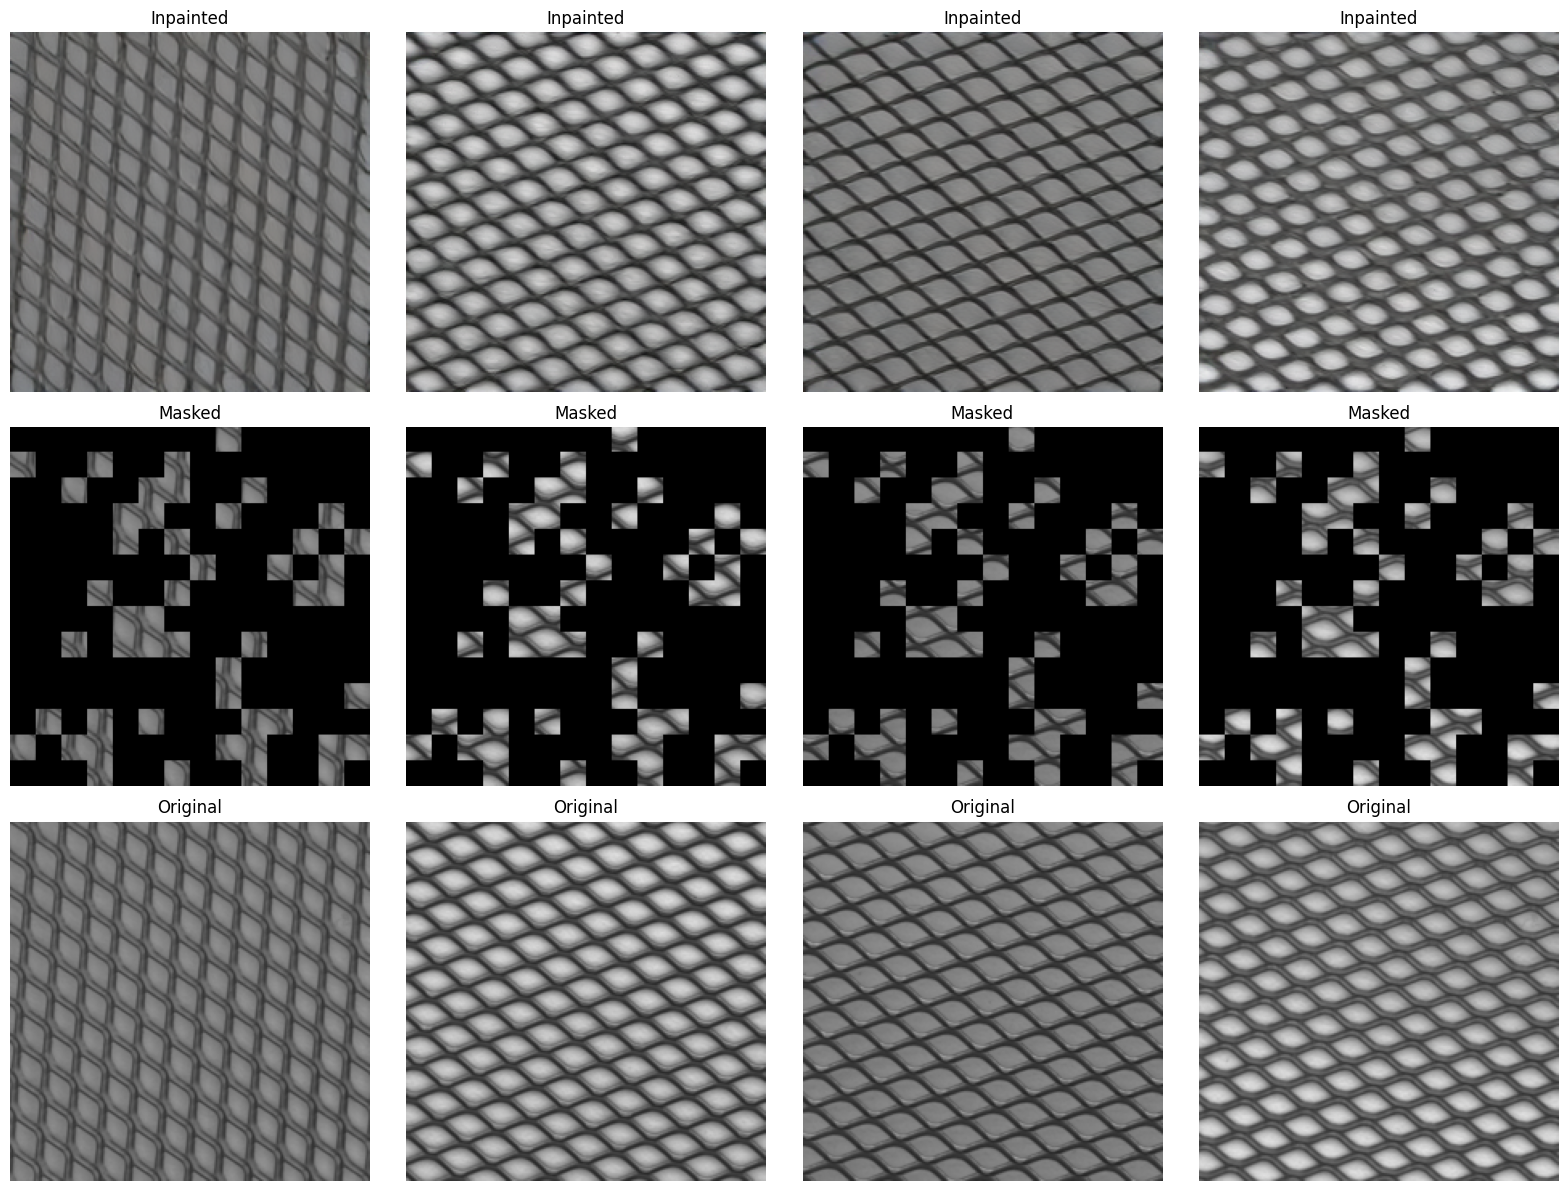

In [140]:
# Show inpainting results
import torch.nn.functional as F

def show_repaint_results(x, mask, images):
    pred_imgs = decode_images(x)  # (B, 3, H, W)
    # pred_imgs = x   
    pred_imgs = convert2image(postprocess(pred_imgs))  # (B, H, W, 3)

    org_imgs = postprocess(images)  # (B, 3, H, W)
    reshaped_mask = F.interpolate(mask, size=(img_size, img_size), mode='nearest')  # (B, 1, H, W)
    masked_imgs = convert2image(org_imgs * (1 - reshaped_mask))  # (B, H, W, 3)

    fig, ax = plt.subplots(3, 4, figsize=(16, 12))
    for i in range(4):
        ax[0, i].imshow(pred_imgs[i])
        ax[1, i].imshow(masked_imgs[i])
        ax[2, i].imshow(convert2image(org_imgs)[i])
        ax[0, i].axis('off')
        ax[1, i].axis('off')
        ax[2, i].axis('off')
        ax[0, i].set_title("Inpainted")
        ax[1, i].set_title("Masked")
        ax[2, i].set_title("Original")
    plt.tight_layout()
    plt.show()

show_repaint_results(x, mask, images)

In [141]:
def anomaly_map(x, y):
    anom_map = torch.mean((x - y)**2, dim=1)  # (B*K, h, w)
    anom_map = anom_map.view(-1, num_samples, 16, 16)  # (B, K, h, w)
    anom_map = torch.min(anom_map, dim=1).values # (B, h, w)
    return anom_map

In [142]:
model_kwargs = {
    'model_type': 'efficientnet-b4',
    'outblocks': (1, 5, 9, 21),
    'outstrides': (2, 4, 8, 16),
    'pretrained': True,
    'stride': 16
}
print(f"Using feature space reconstruction with {model_kwargs['model_type']} backbone")
feature_extractor = get_backbone(**model_kwargs)
feature_extractor.to(device).eval()

Using feature space reconstruction with efficientnet-b4 backbone


BackboneWrapper(
  (backbone): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          48, 12, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          12, 48, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSame

In [144]:
# Calculate anomaly score

def show_detection_results(x, x_org, mask, gt_masks, v_range=None, plot=True, K=1):
    x = mask * x + (1 - mask) * x_org
    decoded_imgs = decode_images(x)
    # images = decode_images(x_org)
    # decoded_imgs = x
    images = decode_images(x_org)
    px_map = torch.mean((decoded_imgs - images)**2, dim=1)  # (B, H, W)

    with torch.no_grad():
        features = feature_extractor(images)
        decoded_features = feature_extractor(decoded_imgs)
        anom_map = anomaly_map(decoded_features, features)  # (B, h, w)
        # px_map = F.interpolate(px_map.unsqueeze(1), size=(anom_map.shape[1], anom_map.shape[2]), mode='bilinear')  # (B, 1, H, W)
        # anom_map += px_map.squeeze(1)
    # anom_map *= mask.squeeze(1)
    if K > 1:  # (BK, h, w)
        anom_map = anom_map.view(-1, K, in_sh[1], in_sh[2])
        anom_map = torch.min(anom_map, dim=1).values.cpu().numpy()  # (B, h, w) 
    else:
        anom_map = anom_map.cpu().numpy()
    bs = anom_map.shape[0]
    reshaped_mask = F.interpolate(mask, size=(img_size, img_size), mode='nearest')
    masked_imgs = convert2image(postprocess(images) * (1 - reshaped_mask))
    # anom_map = anom_map.cpu().numpy()

    decoded_imgs = [decoded_imgs[i*K] for i in range(bs)]
    images = [images[i*K] for i in range(bs)]
    masked_imgs = [masked_imgs[i*K] for i in range(bs)]

    min_score = np.min(anom_map)
    max_score = np.max(anom_map)
    if not plot:
        return min_score, max_score, anom_map
    
    fig, ax = plt.subplots(5, bs, figsize=(16, 12))
    v_range = (min_score, max_score) if v_range is None else v_range
    
    if bs == 1:
        return min_score, max_score, anom_map
    for i in range(bs):
        ax[0, i].imshow(convert2image(postprocess(images[i])))
        ax[1, i].imshow(masked_imgs[i])
        ax[2, i].imshow(convert2image(postprocess(decoded_imgs[i])))
        ax[3, i].imshow(anom_map[i], vmin=v_range[0], vmax=v_range[1])
        ax[4, i].imshow(convert2image(gt_masks[i]))
        ax[0, i].set_title("Original")
        ax[1, i].set_title("Masked Image")
        ax[2, i].set_title("Predicted")
        ax[3, i].set_title("Anomaly Map: {:.2f}".format(np.max(anom_map[i])))
        ax[4, i].set_title("Ground Truth")
        ax[0, i].axis('off')
        ax[1, i].axis('off')
        ax[2, i].axis('off')
        ax[3, i].axis('off')
        ax[4, i].axis('off')
        
    plt.tight_layout()
    plt.show()
    return min_score, max_score, anom_map
    
min_s, max_s, anom_map = show_detection_results(x, x_org, mask, gt_masks)

RuntimeError: shape '[-1, 1, 16, 16]' is invalid for input of size 1568

In [146]:
x_org.shape

torch.Size([8, 16, 14, 14])

In [37]:
print(len(normal_dataloader))
print(len(anom_dataloader))

4
12


In [ ]:
### Iterative mask refinement
num_iter_step = 1
K = 1
# thresh = 5
quant_thresh = 0.8

# Initialize batch and mask
# batch, mask_indices = list(iter(anom_dataloader))[0]
# batch, mask_indices = list(iter(normal_dataloader))[0]
batch, mask_indices = next(iter(train_loader))

normal_scores = []
for batch, mask_indices in normal_dataloader:
    # ensure same mask for all samples
    mask_indices = torch.stack([mask_indices[0] for _ in range(len(batch["samples"]))])

    num_patches = mim_in_sh[1] ** 2
    mask = indices_to_mask(mask_indices, num_patches)
    mask = mask.to(device)
    images = batch["samples"].to(device)
    labels = batch["clslabels"].to(device)
    paths = batch["filenames"]
    gt_masks = batch["masks"]  # (B, 1, H, W) 

    exp_size = 2
    use_gt_mask = False 

    if use_gt_mask:
        gt_masks_ = gt_masks.clone()
        gt_masks_ = gt_mask_to_mask(gt_masks_, in_sh, expand_size=exp_size) # (B, h, w)
        mask = gt_masks_.to(device)
        mask = rearrange(mask, 'b h w -> b (h w)')
        mask = reshape_mask(mask)
    else:
        mask = mask.to(device)
        mask = reshape_mask(mask)

    # indices = list(range(model.sample_diffusion.num_timesteps))[::-1]
    cls_embed = model.cls_embed(labels)  # (B, Z)
    model_kwargs = dict(c=cls_embed, z=None, mask_indices=None, z_vis=None)
    sample_fn = model.net.forward

    # Extract original latents
    # x_org = encode_images(images).repeat_interleave(K, dim=0)  # (B*K, d, h, w)
    x_org = images.repeat_interleave(K, dim=0)  # (B*K, d, h, w)
    mask = mask.repeat_interleave(K, dim=0)  # (B*K, 1, h, w)
    inv_mask = 1 - mask.float() # (B, h, w), 0: masked, 1: unmasked
    mask, inv_mask = mask.unsqueeze(1), inv_mask.unsqueeze(1)  # (B, 1, h, w) 

    # Initialize x_T
    x_T = torch.randn(x_org.shape).to(device)  # (B*K, d, h, w)

    for i in tqdm(range(num_iter_step)):
        x = sample_ddrm(x_T, x_org, mask, inv_mask, sigmas, alphas, indices, device, x_org.shape[0], model)
        min_s, max_s, anom_map = show_detection_results(x, x_org, mask, gt_masks, v_range=None, plot=True, K=K)
        mean = anom_map.mean()
        anom_map = torch.tensor(anom_map)
        anom_scores = anom_map.view(anom_map.shape[0], -1).mean(dim=1)
        # Binarize anomaly map
        # binalize top-quantile score
        thresh = torch.sort(anom_map.view(-1), descending=False)[0][int(quant_thresh * anom_map.numel())]
        anom_map = anom_map > thresh
        anom_map = anom_map.to(device).unsqueeze(1).float()  # (B, 1, h, w)
        anom_map = anom_map.repeat_interleave(K, dim=0)  # (B*K, 1, h, w)
        
        # Update mask with logical and
        # mask = anom_map * mask
        # inv_mask = 1 - mask.float()  # (B, 1, h, w)

        print(f"step [{i+1}/{num_iter_step}], Coverage: {mask.mean().item()}, Anomaly score: [{min_s}, {max_s}, {mean}]")
        print(f"Anomaly scores: {anom_scores}")
    normal_scores.extend(anom_scores.cpu().numpy().tolist())

In [ ]:
### Iterative mask refinement

# Initialize batch and mask
batch, mask_indices = list(iter(anom_dataloader))[0]
# batch, mask_indices = list(iter(normal_dataloader))[2]
# batch, mask_indices = next(iter(train_loader))

anomaly_scores = []
for batch, mask_indices in anom_dataloader:
    # ensure same mask for all samples
    mask_indices = torch.stack([mask_indices[0] for _ in range(len(batch["samples"]))])

    num_patches = mim_in_sh[1] ** 2
    mask = indices_to_mask(mask_indices, num_patches)
    mask = mask.to(device)
    images = batch["samples"].to(device)
    labels = batch["clslabels"].to(device)
    paths = batch["filenames"]
    gt_masks = batch["masks"]  # (B, 1, H, W) 

    exp_size = 2
    use_gt_mask = False 

    if use_gt_mask:
        gt_masks_ = gt_masks.clone()
        gt_masks_ = gt_mask_to_mask(gt_masks_, in_sh, expand_size=exp_size) # (B, h, w)
        mask = gt_masks_.to(device)
        mask = rearrange(mask, 'b h w -> b (h w)')
        mask = reshape_mask(mask)
    else:
        mask = mask.to(device)
        mask = reshape_mask(mask)

    # indices = list(range(model.sample_diffusion.num_timesteps))[::-1]
    cls_embed = model.cls_embed(labels)  # (B, Z)
    model_kwargs = dict(c=cls_embed, z=None, mask_indices=None, z_vis=None)
    sample_fn = model.net.forward

    # Extract original latents
    # x_org = encode_images(images).repeat_interleave(K, dim=0)  # (B*K, d, h, w)
    x_org = images.repeat_interleave(K, dim=0)  # (B*K, d, h, w)
    mask = mask.repeat_interleave(K, dim=0)  # (B*K, 1, h, w)
    inv_mask = 1 - mask.float() # (B, h, w), 0: masked, 1: unmasked
    mask, inv_mask = mask.unsqueeze(1), inv_mask.unsqueeze(1)  # (B, 1, h, w) 

    # Initialize x_T
    x_T = torch.randn(x_org.shape).to(device)  # (B*K, d, h, w)

    for i in tqdm(range(num_iter_step)):
        x = sample_ddrm(x_T, x_org, mask, inv_mask, sigmas, alphas, indices, device, x_org.shape[0], model)
        min_s, max_s, anom_map = show_detection_results(x, x_org, mask, gt_masks, v_range=None, plot=True, K=K)
        mean = anom_map.mean()
        anom_map = torch.tensor(anom_map)
        anom_scores = anom_map.view(anom_map.shape[0], -1).mean(dim=1)
        # Binarize anomaly map
        # binalize top-quantile score
        thresh = torch.sort(anom_map.view(-1), descending=False)[0][int(quant_thresh * anom_map.numel())]
        anom_map = anom_map > thresh
        anom_map = anom_map.to(device).unsqueeze(1).float()  # (B, 1, h, w)
        anom_map = anom_map.repeat_interleave(K, dim=0)  # (B*K, 1, h, w)
        
        # Update mask with logical and
        # mask = anom_map * mask  
        # inv_mask = 1 - mask.float()  # (B, 1, h, w)

        print(f"step [{i+1}/{num_iter_step}], Coverage: {mask.mean().item()}, Anomaly score: [{min_s}, {max_s}, {mean}]")
        print(f"Anomaly scores: {anom_scores}")
    anomaly_scores.extend(anom_scores.cpu().numpy().tolist())

0.6597110754414126

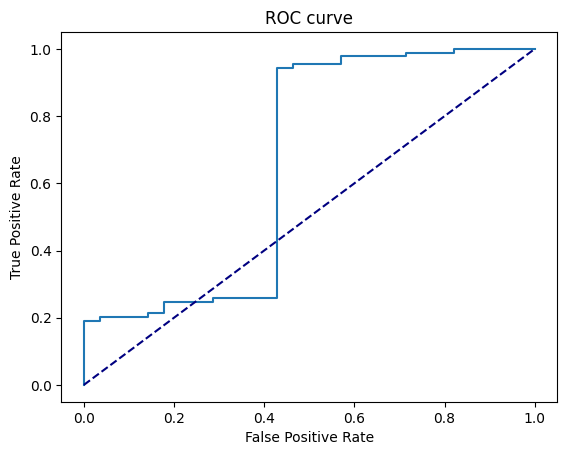

In [46]:
from sklearn.metrics import roc_curve, roc_auc_score
y_true = [1] * len(anomaly_scores) + [0] * len(normal_scores)
y_score = anomaly_scores + normal_scores
fpr, tpr, _ = roc_curve(y_true, y_score)

# plot roc curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

roc_auc_score(y_true, y_score)